# Machine Learning - identificação de dígitos

As técnicas de machine learning divergem das técnicas de programação normal, porque fazem com que os programas em si "aprendam" (reconheçam padrões) sem serem explicitamente programados (sem ser o programador a escrever todos os outputs para cada entrada).

Para que esta aprendizagem efetivamente se desenvolva, é necessária uma grande quantidade de dados e capacidade de processamento para os algoritmos de machine learning. Note-se que estes algoritmos têm uma forte vertente estatística, o que permite, por um lado, saber como fazer o modelo evoluir e, por outro, atestar a sua evolução.

Neste workshop iremos falar e usar 3 modelos de machine learning para a identificação de dígitos escritos. :

1-RandomTreeflorestClassifier 

2-LogisticRegression

3-CNN

Vamos usar a base de dados disponível em https://www.kaggle.com/c/digit-recognizer/data

## Importação dos dados e vizualização

Para ler os dados e manipulá-los, vamos usar a biblioteca pandas (biblioteca que cria e manipula estrutras de dados com uma grande performance).Para vizualizar dados iremos usar o matplotlib e o skimage.io.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib

from sklearn.utils import shuffle

from skimage.io import imread, imshow

df = pd.read_csv("train.csv")
df=shuffle(df)

y = df.loc[:,'label'].values
x = df.drop("label",axis=1).values

In [2]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29497,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32545,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29178,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28003,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


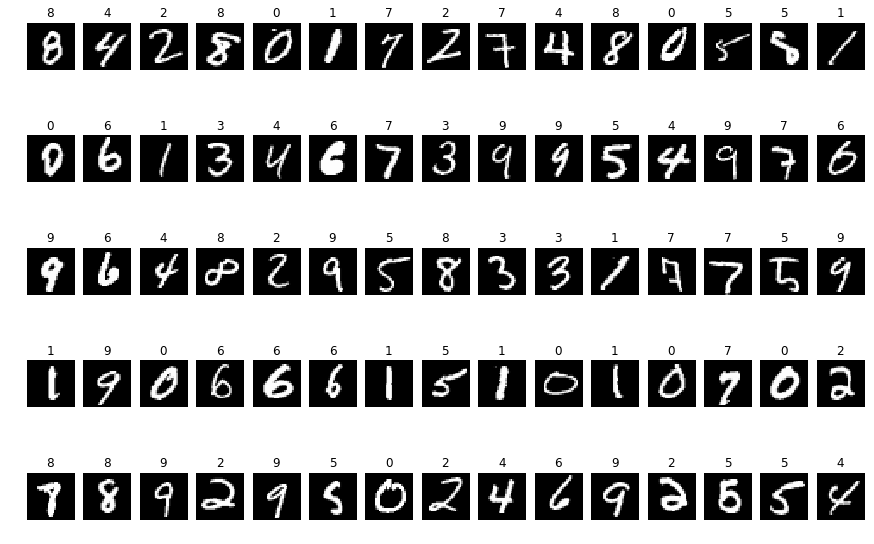

In [3]:
fig1, ax1 = plt.subplots(5,15, figsize=(15,10))
for j in range(15):
    for i in range(5):
        ax1[i][j].imshow(x[i+15*j].reshape((28,28)),'gray')
        ax1[i][j].axis('off')
        ax1[i][j].set_title(y[i+15*j])
plt.show()

Vamos testar um modo de diminuir a dimensão dos dados, substituindo o gradiente de cor por uma variável binaria (0 se luminosidade inferior a 125 e 256 se superior).

In [4]:
y_red = y
x_red = x

#for line in range (x_train_red.shape[0]):
#    for col in range (x_train_red.shape[1]):
#        if(x_train_red[line][col] <126):
#            x_train_red[line][col]=0
#        else:
#            x_train_red[line][col]=256

x_red=np.vectorize(lambda a:0 if a<126 else 256)(x)

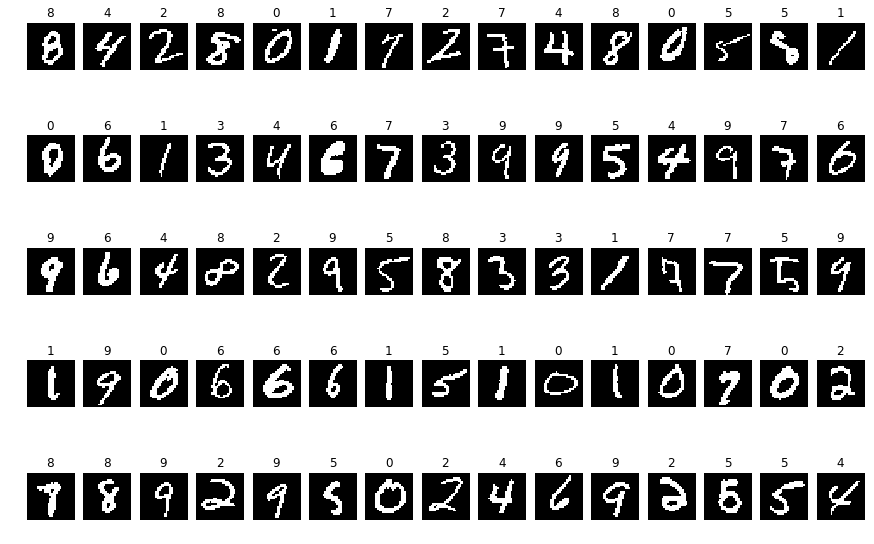

In [5]:
fig1, ax1 = plt.subplots(5,15, figsize=(15,10))
for j in range(15):
    for i in range(5):
        ax1[i][j].imshow(x_red[i+15*j].reshape((28,28)),'gray')
        ax1[i][j].axis('off')
        ax1[i][j].set_title(y[i+15*j])
plt.show()

# Modelização

Um algoritmo de machine learning de classificação (neste caso especifico queremos classificar as imagens com um dos 10 dígitos) é um algoritmo que recebe um train_dataset com as respetivas tags (dígitos que correspondem a imagens) e cria o modelo de decisão com o objetivo de prever corretamente o resultado do test_dataset. Para corretamente avaliar a sua performance será necessário dividi-lo em train e test sets.

In [6]:


x_train=x[0:35000,:]
y_train=y[0:35000]

x_train_red=x_red[0:35000,:]
y_train_red=y_red[0:35000]

x_test=x[35000:,:]
y_test=y[35000:]

x_test_red=x_red[35000:,:]
y_test_red=y_red[35000:]

## RandomTreeFlorestClassification

Tal como o nome indica, uma decision tree está estruturada em forma de árvore e organiza a sua decisão num esquema composto pelo topo da árvore (dataset), por nós(condições que subdividem o dataset) e por folhas (o final de cada ramo onde se encontra a previsão para cada dado que sair).Tomemos como exemplo o seguinte dataset simplificado:

Exemplo da estrutura:
 
<img src="tree_example.png">

In [7]:
col=["sexo","num Sbs","idade>9.5 ?","survived"]
dat=[
     ["M",3,1 ,0 ],
     ["M",2,1,0 ],
     ["M",1,1 ,0],
     ["M",1,0,0],
     ["M",2,0,1],
     ["F",2,0,1],
     ["F",1,1,1 ],
     ["F",1,1,1 ],
     ["F",0,1,1 ],
     ["F",0,1,0 ]
    
]
example_df=pd.DataFrame(data=dat,columns=col)
print("Dados para desenhar uma ClassificationTree:")
example_df



Dados para desenhar uma ClassificationTree:


,sexo,num Sbs,idade>9.5 ?,survived
0,M,3,1,0
1,M,2,1,0
2,M,1,1,0
3,M,1,0,0
4,M,2,0,1
5,F,2,0,1
6,F,1,1,1
7,F,1,1,1
8,F,0,1,1
9,F,0,1,0


Este algoritmo que vamos ver utiliza a técnica greedy de partição do dataset, que utiliza como critério o corte que diminui mais a entropia do dataset. Para saber mais sobre entropia: http://www.saedsayad.com/decision_tree.htm .Para além disso para aumentar o grau de confiança no resultado este algoritmo não cria uma, mas várias decisiontrees para garantir uma decisão mais robusta.(menor desvio padrão).

Cálculo da entropia :
\begin{equation}\label{Cálculo da entropia}
    E(S)=\sum_{i=1}^{c}-p_{i}\log_{2}{p_{i}}
\end{equation}


### Crianção do modelo RandomTree:

In [8]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score as ac_score

In [9]:
tree_classifier = RFC(max_depth=17,criterion='entropy')
tree_classifier.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
#ver train score
tree_predictions=tree_classifier.predict(x_train)
ac_score(y_train,tree_predictions)

0.99831428571428571

In [11]:
#ver test score
tree_predictions=tree_classifier.predict(x_test)
ac_score(y_test,tree_predictions)

0.94171428571428573

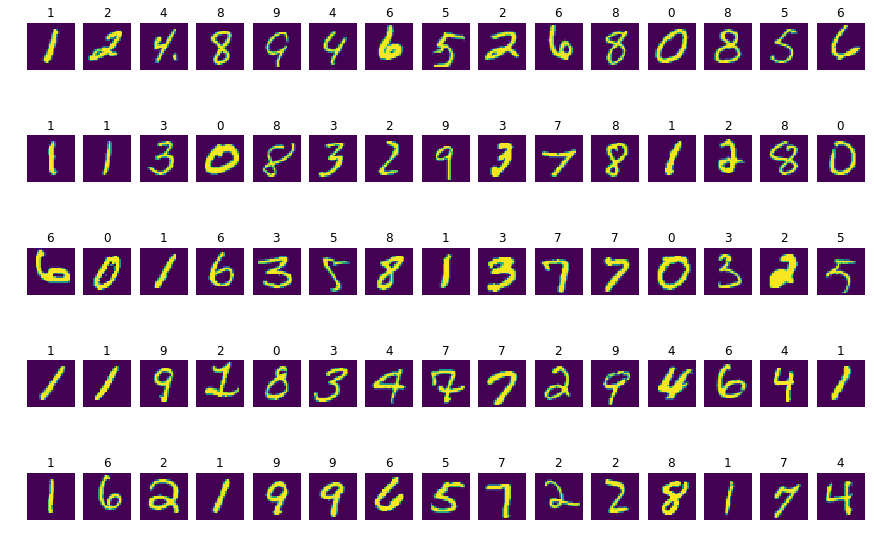

In [12]:
fig1, ax1 = plt.subplots(5,15, figsize=(15,10))
for j in range(15):
    for i in range(5):
        ax1[i][j].imshow(x_test[i+15*j].reshape((28,28)))
        ax1[i][j].axis('off')
        ax1[i][j].set_title(tree_predictions[i+15*j])
plt.show()

In [13]:
#msm coisa para o reduzido
tree_classifier = RFC(max_depth=2000)
tree_classifier.fit(x_train_red,y_train_red)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
#atestar train score
tree_predictions=tree_classifier.predict(x_train_red)
ac_score(y_train_red,tree_predictions)

0.9988285714285714

In [15]:
#atestar test score
tree_predictions=tree_classifier.predict(x_test_red)
ac_score(y_test_red,tree_predictions)

0.93257142857142861

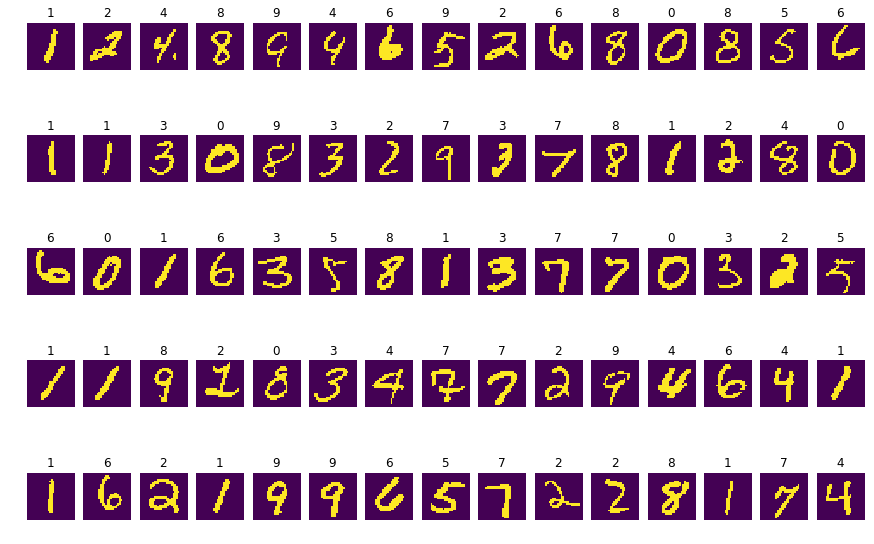

In [16]:
fig1, ax1 = plt.subplots(5,15, figsize=(15,10))
for j in range(15):
    for i in range(5):
        ax1[i][j].imshow(x_test_red[i+15*j].reshape((28,28)))
        ax1[i][j].axis('off')
        ax1[i][j].set_title(tree_predictions[i+15*j])
plt.show()

## logistic_classifier:

Este modelo é o modelo mais usado em áreas de investigação aplicadas (investigações médicas, farmacêuticas, ciências sociais).A vantagem que tem em relação aos outros é ser um modelo amplamente aceite e com critérios de creditação do modelo já muito estudados e ajustáveis para uma grande diversidades de datasets.


A função sigmoid:
<img src="logistic.png">

O que o modelo faz, a duas dimensões, é encontrar a curva com a forma de cima que melhor se ajusta aos dados encontrados (Redução por mínimos quadrados) e depois, para cada observação, calcula o resultado da função nesse ponto, que é diretamente traduzido numa probabilidade (a função tem sempre valores entre 0 e 1)

Exemplo :
<img src="log_2.png">

Quando o problema tem mais do que uma variável resultado (neste caso há 10). O modelo usa inferência estatística, recorrendo ao teorema de Bayes como ponto inicial para a classificação (calcula qual a probabilidade de ser 0 face à de ser 1 e faz isso para todas as possibilidades, e procura o modelo que maximize a probabilidade total de sucesso).Para mais informações, um bom ponto de partida é https://en.wikipedia.org/wiki/Multinomial_logistic_regression

### Criação do modelo logit:

In [17]:
#dataset mt extenso para este método diminuir dados
# +- 1 min a correr
x_train_red_1=x_train_red[0:5000,:]
y_train_red_1=y_train_red[0:5000]

#idiota erro gravissimo
x_test_red_1=x_test_red[0:500]
y_test_1=y_test[0:500]


from sklearn.linear_model import LogisticRegression
logi_classifier=LogisticRegression(verbose =50)
logi_classifier.fit(x_train_red_1,y_train_red_1)
prediction=logi_classifier.predict(x_test_red_1)
ac_score(y_test_1,prediction)

[LibLinear]

/home/ricostynha/.local/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.80200000000000005

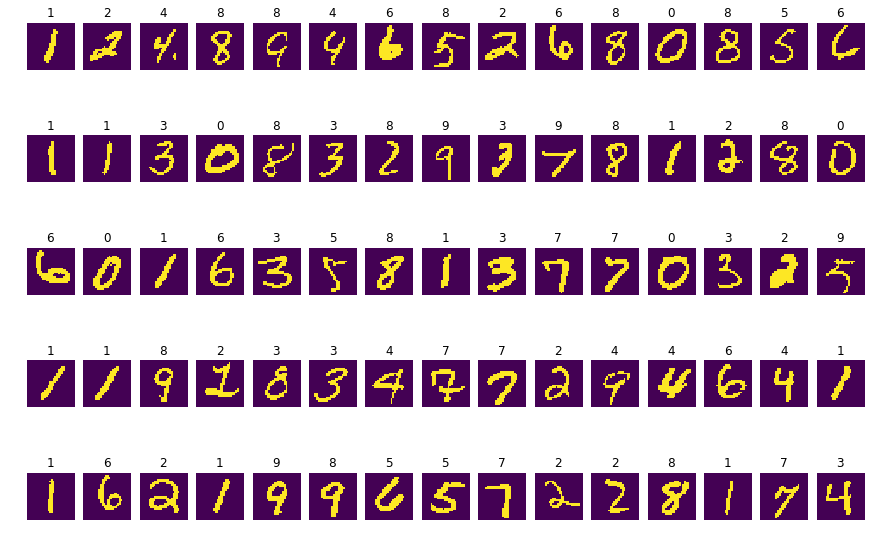

In [18]:
fig1, ax1 = plt.subplots(5,15, figsize=(15,10))
for j in range(15):
    for i in range(5):
        ax1[i][j].imshow(x_test_red_1[i+15*j].reshape((28,28)))
        ax1[i][j].axis('off')
        ax1[i][j].set_title(prediction[i+15*j])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix as c_matrix

In [20]:
print(c_matrix(y_test_1,prediction))

[[44  0  0  0  0  0  0  0  0  2]
 [ 1 65  1  0  0  0  0  0  1  2]
 [ 0  0 45  5  1  0  1  0  5  1]
 [ 2  0  0 41  0  1  0  2  6  4]
 [ 0  0  2  3 26  0  1  0  3  3]
 [ 0  2  0  3  2 31  1  0  6  2]
 [ 1  0  0  0  0  1 44  0  0  0]
 [ 0  0  1  0  0  0  0 47  0  7]
 [ 0  3  1  1  0  3  0  1 37  2]
 [ 0  0  0  1  2  1  0  4  7 21]]


In [21]:
#meter aqui quantos 0 foram classficados como 1...2..9 etc

matrix=np.zeros((10,10))

for line in range(10):
    unique, counts=np.unique(prediction[y_test_1 == line],return_counts=True)
    matrix[line][unique]=counts
    
viz=pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9],columns=[0,1,2,3,4,5,6,7,8,9],data=matrix)
viz

,0,1,2,3,4,5,6,7,8,9
0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.0,65.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,0.0,0.0,45.0,5.0,1.0,0.0,1.0,0.0,5.0,1.0
3,2.0,0.0,0.0,41.0,0.0,1.0,0.0,2.0,6.0,4.0
4,0.0,0.0,2.0,3.0,26.0,0.0,1.0,0.0,3.0,3.0
5,0.0,2.0,0.0,3.0,2.0,31.0,1.0,0.0,6.0,2.0
6,1.0,0.0,0.0,0.0,0.0,1.0,44.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,47.0,0.0,7.0
8,0.0,3.0,1.0,1.0,0.0,3.0,0.0,1.0,37.0,2.0
9,0.0,0.0,0.0,1.0,2.0,1.0,0.0,4.0,7.0,21.0


## Redes de Convolução Neuronais

As redes de convulsão neuronais, apesar de serem já conhecidas desde 1950, só começaram a ter a atenção do mundo de machine learning quando, em 2012, Ciresan et al melhoraram muito o melhor modelo na literatura para identificação de imagens. Já muitas tentativas foram feitas para utilizar este modelo noutro tipos de modelos (que não reconhecimento de imagem ou vídeo) sem muito sucesso. Este modelo é muito pesado computacionalmente.
 
Decidi abordar este modelo por ser intuitivo no modo como funciona e ter uma alta performance. Para ter um entendimento mais aprofundado sobre o tema, podem ler este paper da autoria de Jianxin Wu: https://pdfs.semanticscholar.org/450c/a19932fcef1ca6d0442cbf52fec38fb9d1e5.pdf. Para saber mais sobre polling, podem ler este paper da autoria de Dominic Shrerer http://ais.uni-bonn.de/papers/icann2010_maxpool.pdf.

<img src="CNN_image.jpg">

Operador Convolução (usado para detectar features nos dados):
\begin{equation}\label{Convulusãp}
   f(t)*g(t)=\int_{y=-\infty}^{+\infty} f(y)*g(t-y)dy
\end{equation}


<img src="convulucao/Diapositivo1.JPG">


Para observar os efeitos de diferentes feature detectores, iremos ver a documentação do programa Gimp (um programa de edição de imagem):
https://docs.gimp.org/en/plug-in-convmatrix.html

Pooling (usado para diminuir a complexidade dos dados e dar mais relacionamento estrutural):


<img src="convulucao/Diapositivo2.JPG">

Para ver tudo em ação: http://scs.ryerson.ca/~aharley/vis/conv/flat.html

A party fully connected não será abordada neste workshop. Para saberem mais, podem ver o research paper referido supramencionado ou numa próxima edição deste workshop mediante sugestões. (também estou aberto a questões sobre esta parte no fim do workshop).

### Contruindo aCNN

Como nos outros casos, começaremos com as importações das bibliotecas a usar:

In [22]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

Using TensorFlow backend.


Construir a rede em si:

In [35]:
# 1 - Convulução:
#foram escolhidos 32 features detectores
classifier = Sequential()
classifier.add(Convolution2D(32, (3, 3), input_shape = (28, 28,1), activation = 'relu'))

In [36]:
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [37]:
# Adding a second convolutional layer
classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [38]:
# Step 3 - Flattening
classifier.add(Flatten())

In [39]:
# Step 4 - Full connection
classifier.add(Dense(units = 28*2, activation = 'relu'))
# Step 4 - Full connection
classifier.add(Dense(units = 28*2, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'sigmoid'))

In [40]:
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Fazer fit dos dados à rede:

In [41]:
#fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0,
#validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, 
#steps_per_epoch=None, validation_steps=None)

X_train=x_train.reshape(-1,28,28,1)
x_test_conv=x_test.reshape(-1,28,28,1)
Y_train = to_categorical(y_train, num_classes = 10)

classifier.fit(X_train, Y_train, batch_size = 90, epochs = 5,validation_split=0.1, verbose = 2 ,shuffle=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
 - 20s - loss: 0.1330 - acc: 0.9567 - val_loss: 0.0424 - val_acc: 0.9853
Epoch 2/5
 - 19s - loss: 0.0326 - acc: 0.9892 - val_loss: 0.0256 - val_acc: 0.9913
Epoch 3/5
 - 19s - loss: 0.0230 - acc: 0.9923 - val_loss: 0.0299 - val_acc: 0.9901
Epoch 4/5
 - 18s - loss: 0.0178 - acc: 0.9942 - val_loss: 0.0239 - val_acc: 0.9921
Epoch 5/5
 - 19s - loss: 0.0148 - acc: 0.9951 - val_loss: 0.0189 - val_acc: 0.9941


In [42]:
# Predict the values from the validation dataset
Y_pred_CNN = classifier.predict(x_test_conv)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred_CNN,axis = 1) 


In [43]:
ac_score(y_test,Y_pred_classes)

0.97628571428571431

In [44]:
viz=pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9],columns=[0,1,2,3,4,5,6,7,8,9],data=c_matrix(y_test,Y_pred_classes))
viz

,0,1,2,3,4,5,6,7,8,9
0,687,0,1,0,1,0,9,1,1,0
1,0,795,3,2,0,1,0,5,1,0
2,0,1,680,8,1,0,0,6,3,1
3,1,1,4,707,0,1,0,2,1,2
4,2,1,1,0,676,1,5,0,5,3
5,1,0,0,9,1,605,6,0,2,0
6,2,0,1,0,5,1,670,0,0,0
7,1,2,7,4,0,0,0,696,0,0
8,1,2,0,2,3,2,6,1,643,1
9,2,1,3,4,12,0,1,6,2,675


Ver os erros cometidos

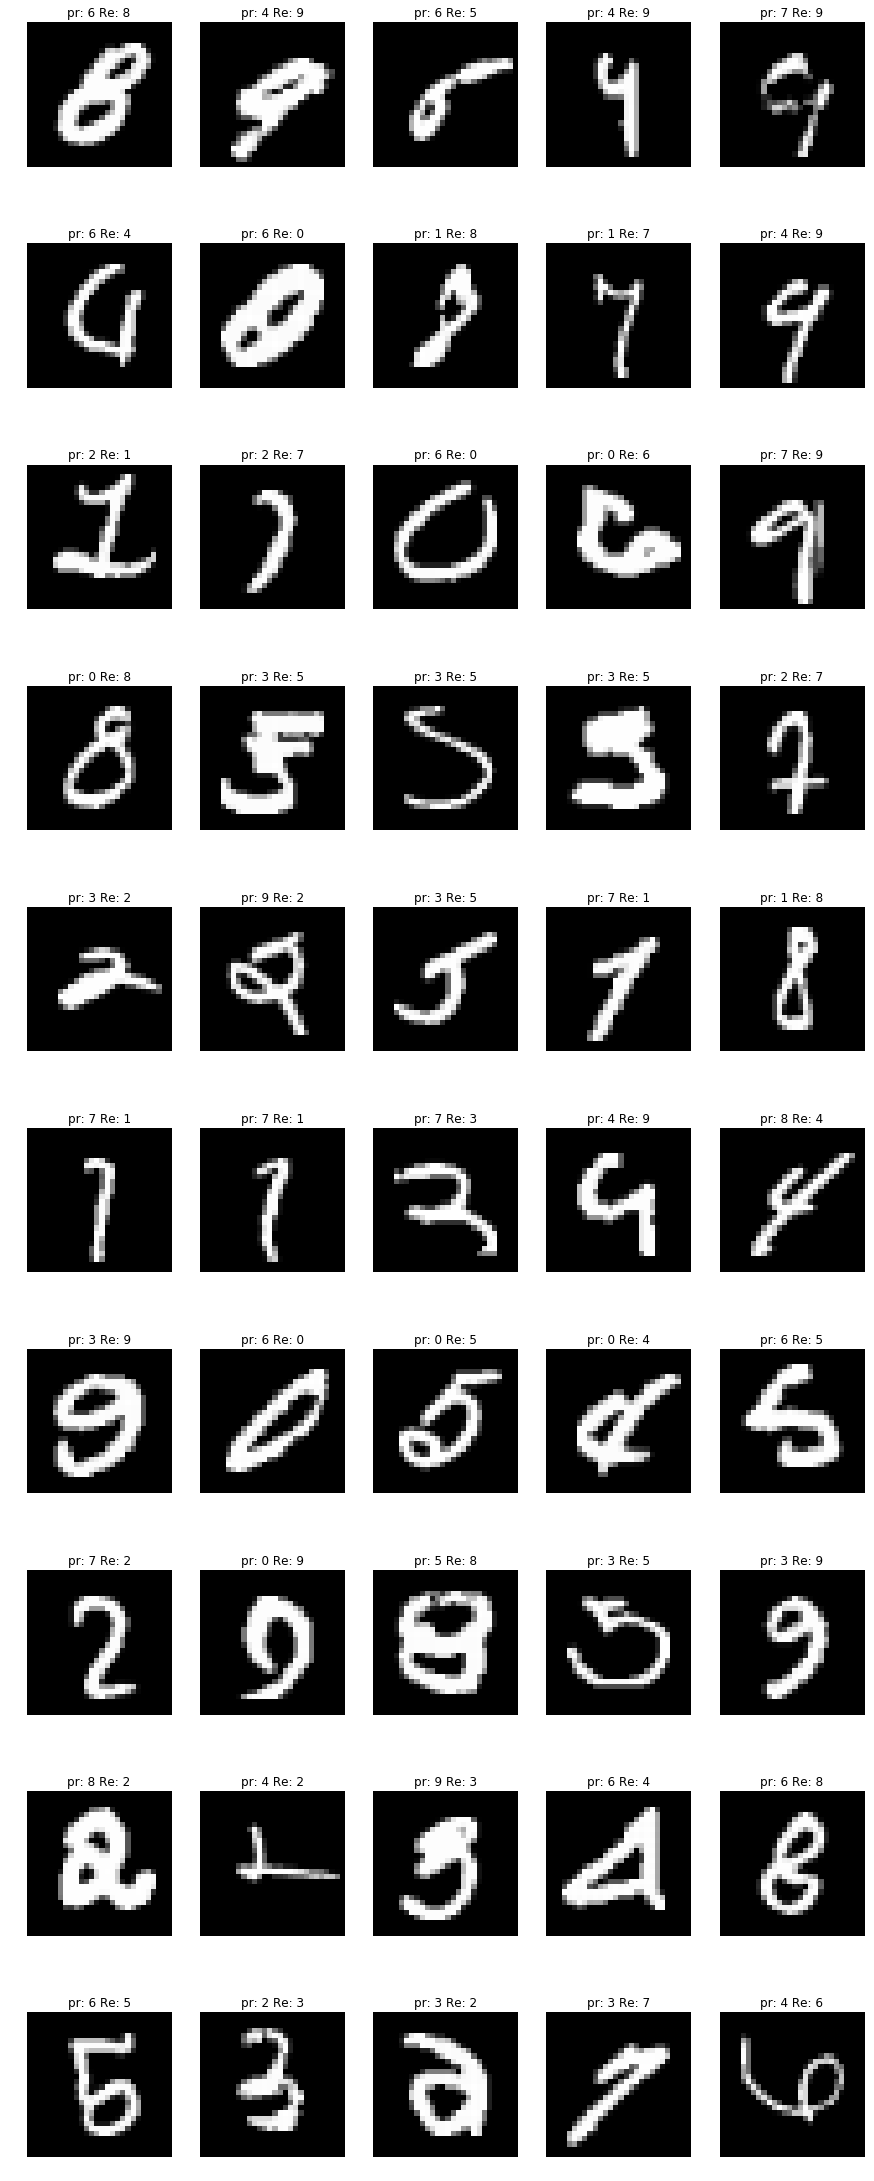

In [45]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - y_test != 0)

fig1, ax1 = plt.subplots(10,5, figsize=(15,40))
for j in range(5):
    for i in range(10):
        ax1[i][j].imshow(x_test[errors][i+10*j].reshape((28,28)),'gray')
        ax1[i][j].axis('off')
        title="pr: "+(str)(Y_pred_classes[errors][i+10*j]) +" Re: "+(str)(y_test[errors][i+10*j])
        ax1[i][j].set_title(title)
plt.show()
